## RSI

#### RSI 指标的使用方法
##### 1：超买超卖
+ RSI > 70：超买区，价格可能见顶，考虑卖出。
+ RSI < 30：超卖区，价格可能见底，考虑买入。

##### 2: RSI 金叉、死叉
+ RSI 上穿 30（由下往上）：短线买入信号。
+ RSI 下穿 70（由上往下）：短线卖出信号。
##### 3:RSI 背离
+ 股价创新高，RSI 没创新高 → 顶部背离，可能下跌。
+ 股价创新低，RSI 没创新低 → 底部背离，可能上涨。


In [18]:
# 获取数据源
import baostock as bs
import pandas as pd
import logging
import numpy as np

def get_k_data(code, start, end):
    lg = bs.login()
    # 显示登陆返回信息
    logging.info('login respond error_code:' + lg.error_code)
    logging.info('login respond  error_msg:' + lg.error_msg)
    # 获取股票数据
    rs = bs.query_history_k_data_plus(code,
                                              "date,open,high,low,close,volume",
                                              start_date=start,
                                              end_date=end,
                                              frequency="d",
                                              adjustflag="3")  # adjustflag="3"表示不复权
    data = rs.get_data()


    # 登出baostock系统
    bs.logout()

    # 创建DataFrame
    df = data[['date', 'open', 'high', 'low', 'close', 'volume']].rename(columns={'date': 'Date'})

    # 转换日期格式
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)  # 设置日期列为索引

    # 将空字符串替换为 NaN
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].replace('', np.nan)
    # 去除包含空值的行
    df = df.dropna(subset=['open', 'high', 'low', 'close', 'volume'])

    # 将股价数据转换为数值类型
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df

In [19]:
stock_code = "sh.603486"  
start_date = "2024-01-01"
end_date = "2025-12-31"

df = get_k_data(stock_code, start_date, end_date)

login success!
logout success!


In [20]:
import talib
import mplfinance as mpf
import matplotlib.pyplot as plt

# 计算 RSI（通常使用 14 日作为参数）
df['RSI'] = talib.RSI(df['close'], timeperiod=14)

# --- 2. 标记信号 ---
# 买入信号：当 RSI 前一日小于 30，今日 RSI 大于或等于 30
df['buy_signal'] = (df['RSI'].shift(1) < 30) & (df['RSI'] >= 30)
# 卖出信号：当 RSI 前一日大于 70，今日 RSI 小于或等于 70
df['sell_signal'] = (df['RSI'].shift(1) > 70) & (df['RSI'] <= 70)

# 为在主图（股票价格图）上标记信号，用收盘价加上合理偏移量（避免被K线遮挡）
df['buy_point'] = np.where(df['buy_signal'], df['close'] * 0.99, np.nan)   # 买点略低于收盘价
df['sell_point'] = np.where(df['sell_signal'], df['close'] * 1.01, np.nan) # 卖点略高于收盘价





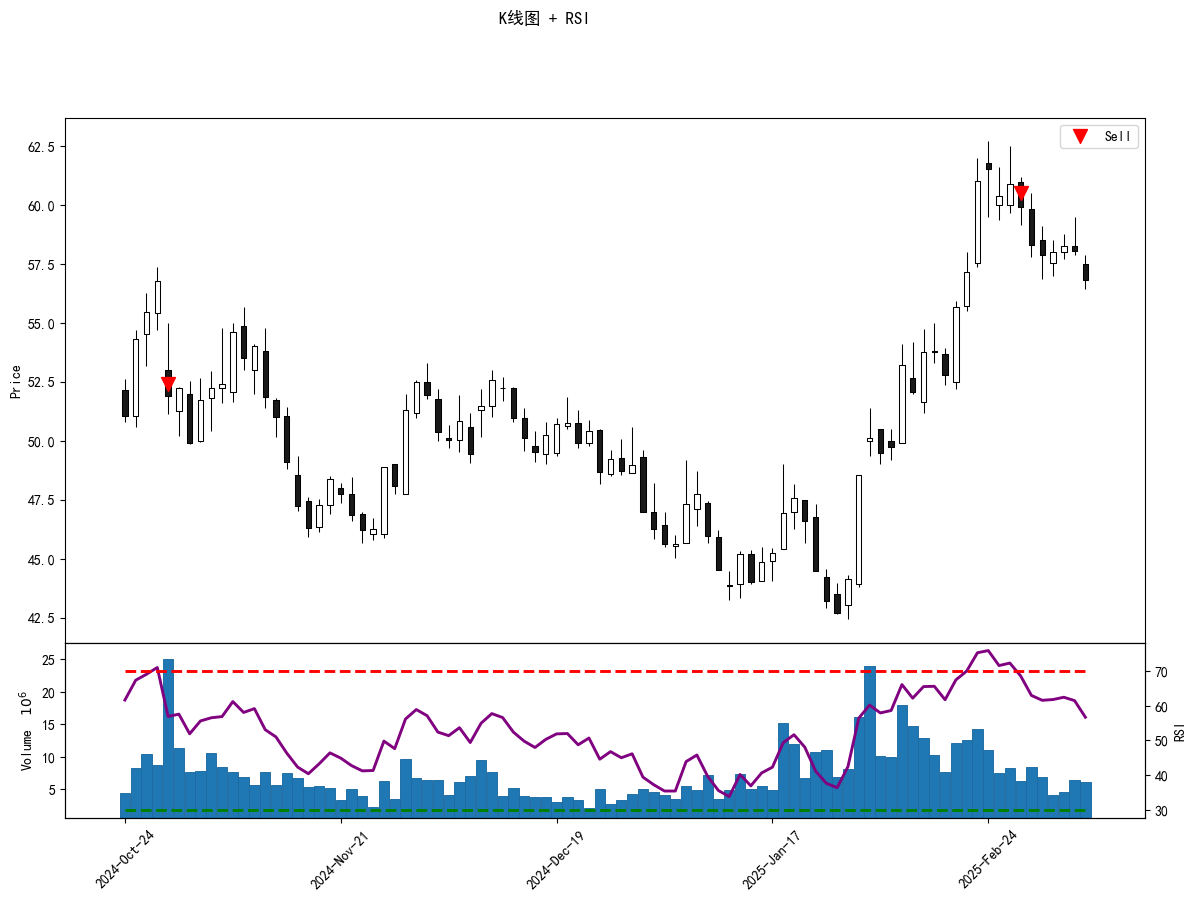

In [21]:
# 只取最近90天数据（可根据需要调整）
df = df.tail(90)

# 创建附加图，将 RSI 绘制在单独的面板中（panel=1）
ap_rsi = mpf.make_addplot(df['RSI'], panel=1, color='purple', ylabel='RSI')

# 定义自定义风格（这里设置中文字体以避免乱码）
my_style = mpf.make_mpf_style(rc={'font.sans-serif': ['SimHei'],
                                  'axes.unicode_minus': False})


# 在 RSI 面板添加 30 和 70 参考线
ap_rsi30 = mpf.make_addplot(np.full(len(df), 30), panel=1, color='green', linestyle='--')
ap_rsi70 = mpf.make_addplot(np.full(len(df), 70), panel=1, color='red', linestyle='--')

# 在主图（panel=0）上标记买卖信号，使用散点图
ap_buy = mpf.make_addplot(df['buy_point'], panel=0, type='scatter', markersize=100, marker='^', color='g', label='Buy')
ap_sell = mpf.make_addplot(df['sell_point'], panel=0, type='scatter', markersize=100, marker='v', color='r', label='Sell')


# 组合所有附加图对象
apds = [ap_rsi, ap_rsi30, ap_rsi70]

if df['buy_point'].count() > 0:
    apds.append(ap_buy)

if df['sell_point'].count() > 0:
    apds.append(ap_sell)


# 绘制图表：上部为 K 线图，下部为 RSI 面板；同时显示成交量
mpf.plot(df, type='candle', style=my_style, addplot=apds, volume=True, figsize=(15,10),
         title="K线图 + RSI", panel_ratios=(3,1))

plt.show()